In [1]:
import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf


In [2]:
# 预处理输入数据
def preprocessing(nmp_df,power_df):
    nmp_df.head(10)
    power_df.head(10)
    fix_df=pd.merge(nmp_df, power_df, on=['Datetime'], how='left')
    fix_df.head(10)
    fix_df.describe()

    return fix_df

In [3]:
# 读取数据
his_nmp_gf_df = pd.read_csv('.\\data\\GF001\\03 His_NWP_GF.csv',parse_dates=["Datetime"],index_col=[0])
his_power_gf_df = pd.read_csv('.\\data\\GF001\\02 His_Power_GF.csv',parse_dates=["Datetime"],index_col=[0])
his_gf_df=preprocessing(his_nmp_gf_df,his_power_gf_df)
his_gf_df.to_csv('his_gf.csv',encoding = 'utf-8') #存储合并后数据

In [4]:
df=pd.read_csv('his_gf.csv',parse_dates=["Datetime"],index_col=[0])
df.head()

,Irradiance,Speed10,Direction10,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,
2022-06-13 00:00:00,0.0,6.9614,14.8148,27.32,998.67,92.59,0.0
2022-06-13 00:15:00,0.0,7.0349,15.1623,27.33,998.68,92.40,0.0
2022-06-13 00:30:00,0.0,7.1234,14.3874,27.31,998.54,92.42,0.0
2022-06-13 00:45:00,0.0,7.2816,15.6968,27.29,998.21,92.27,0.0
2022-06-13 01:00:00,0.0,7.2544,18.7347,27.34,997.92,91.92,0.0


In [5]:
df.tail()

,Irradiance,Speed10,Direction10,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,
2022-06-19 22:45:00,0.0,8.8735,7.3813,27.97,997.04,91.88,0.0
2022-06-19 23:00:00,0.0,7.6355,357.8234,27.16,996.98,0.00,0.0
2022-06-19 23:15:00,0.0,7.0539,352.9153,27.19,997.26,0.00,0.0
2022-06-19 23:30:00,0.0,6.7206,350.5797,27.27,997.28,0.00,0.0
2022-06-19 23:45:00,0.0,7.0146,352.2164,27.27,996.74,0.00,0.0


In [6]:
df.shape

(672, 7)

In [7]:
# 划分train valid test集
gf_df_train = df[:int(0.6*len(df))]
gf_df_valid = df[int(0.6*len(df)):int(0.8*len(df))]
gf_df_test =df[int(0.8*len(df)):]

In [8]:
gf_df_train

,Irradiance,Speed10,Direction10,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,
2022-06-13 00:00:00,0.0,6.9614,14.8148,27.32,998.67,92.59,0.0
2022-06-13 00:15:00,0.0,7.0349,15.1623,27.33,998.68,92.40,0.0
2022-06-13 00:30:00,0.0,7.1234,14.3874,27.31,998.54,92.42,0.0
2022-06-13 00:45:00,0.0,7.2816,15.6968,27.29,998.21,92.27,0.0
2022-06-13 01:00:00,0.0,7.2544,18.7347,27.34,997.92,91.92,0.0
...,...,...,...,...,...,...,...
2022-06-17 03:30:00,0.0,6.4324,19.0546,27.67,998.19,90.43,0.0
2022-06-17 03:45:00,0.0,6.4961,19.3275,27.65,998.17,90.19,0.0
2022-06-17 04:00:00,0.0,6.4812,19.7490,27.62,998.24,90.29,0.0


In [9]:
# # 划分train valid test集
# fd_df_train = df[:int(0.6*len(df))]
# fd_df_valid = df[int(0.8*len(df)):]
# fd_df_test =df[int(0.8*len(df)):]

In [10]:
# 对数据进行归一化处理
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(df)
df_for_training_scaled = scaler.transform(gf_df_train)
df_for_validing_scaled=scaler.transform(gf_df_valid)
df_for_testing_scaled=scaler.transform(gf_df_test)

In [11]:
# 分离x与y
def createXY(array, days_used_to_train=7):
    features = list()
    labels = list()

    for i in range(days_used_to_train, len(array)):
        features.append(array[i-days_used_to_train:i, :])
        labels.append(array[i, -1])
    return np.array(features), np.array(labels)

train_X,train_y=createXY(df_for_training_scaled)
valid_X,valid_y=createXY(df_for_validing_scaled)
test_X,test_y=createXY(df_for_testing_scaled)

In [12]:
df_X,df_y=createXY(np.array(df))

In [13]:
train_X.shape

(396, 7, 7)

In [14]:
train_y.shape

(396,)

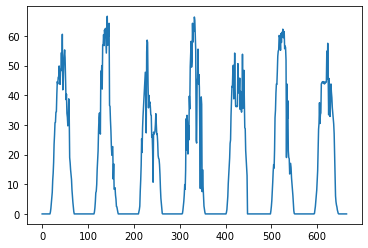

In [15]:
plt.plot(range(len(df_y)), df_y, label='history')

In [16]:
# 定义一个新的评价函数
def ev(y_true, y_predict):
    difference=(abs(np.array(y_true) - np.array(y_predict.flatten()))).sum()
    return float(difference) 

In [17]:
# 建立模型函数
def build_model(size):
    tf.random.set_seed(1) #设置随机数种子
    # Create grid_model
    grid_model = tf.keras.Sequential()
    grid_model.add(tf.keras.layers.LSTM(units=64))
    grid_model.add(tf.keras.layers.Dense(64))
    grid_model.add(tf.keras.layers.Dense(size))
    grid_model.add(tf.keras.layers.Dense(1))

    # Compile the grid_model
    grid_model.compile(
    optimizer='adam',
    loss='mse')
    
    return grid_model

In [18]:
# 为循环初始化一些数据
bestscore=1000
flag=0


In [19]:
i=0
best_size=0
best_batch_size=0
best_epochs=0
# 开始循环（warning不影响做）
for size in [32,16]:
    for batch_size in [8,16]:
        for epochs in range(30,50,10):
            grid_model=build_model(size)
            grid_model.fit(
            train_X, train_y,
            validation_data=(valid_X, valid_y),
            batch_size=32,
            epochs=epochs,
            verbose=0)
            pred_valid_y = grid_model.predict(valid_X)
            score=ev(valid_y,pred_valid_y)
            print(score,'num:',i,'size=',size,'batch_size=',batch_size,'epochs=',epochs)
            i=i+1
            if score<bestscore:
                flag=1
                bestscore=score
                best_size=size
                best_batch_size=batch_size
                best_epochs=epochs
                # Export the model to a SavedModel
                grid_model.save('keras_model_tf_version', save_format='tf')
print(bestscore,'best_size=',best_size,'best_batch_size=',best_batch_size,'best_epochs=',best_epochs)

4/4 [==============================] - 0s 3ms/step
9.41757225952917 num: 0 size= 32 batch_size= 8 epochs= 30


INFO:tensorflow:Assets written to: keras_model_tf_version\assets


INFO:tensorflow:Assets written to: keras_model_tf_version\assets


4/4 [==============================] - 0s 3ms/step
6.01359432747125 num: 1 size= 32 batch_size= 8 epochs= 40


INFO:tensorflow:Assets written to: keras_model_tf_version\assets


INFO:tensorflow:Assets written to: keras_model_tf_version\assets


4/4 [==============================] - 0s 3ms/step
9.41757225952917 num: 2 size= 32 batch_size= 16 epochs= 30
4/4 [==============================] - 0s 2ms/step
6.01359432747125 num: 3 size= 32 batch_size= 16 epochs= 40
4/4 [==============================] - 0s 4ms/step
7.678519991859879 num: 4 size= 16 batch_size= 8 epochs= 30
4/4 [==============================] - 0s 2ms/step
6.0040917377907235 num: 5 size= 16 batch_size= 8 epochs= 40


INFO:tensorflow:Assets written to: keras_model_tf_version\assets


INFO:tensorflow:Assets written to: keras_model_tf_version\assets


4/4 [==============================] - 0s 2ms/step
7.678519991859879 num: 6 size= 16 batch_size= 16 epochs= 30
4/4 [==============================] - 0s 4ms/step
6.0040917377907235 num: 7 size= 16 batch_size= 16 epochs= 40
6.0040917377907235 best_size= 16 best_batch_size= 8 best_epochs= 40


In [20]:
# Recreate the exact same model
my_model = tf.keras.models.load_model('keras_model_tf_version')
new_pred_valid_y=my_model.predict(valid_X)
score=ev(valid_y,new_pred_valid_y)
score

4/4 [==============================] - 0s 2ms/step


6.0040917377907235

4/4 [==============================] - 0s 2ms/step


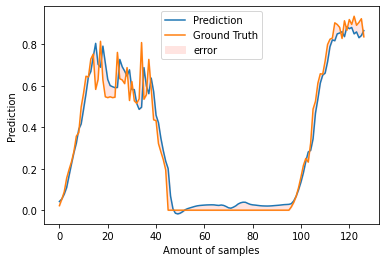

In [21]:
# 查看valid集预测结果
pred_valid_y = my_model.predict(valid_X)
plt.plot(range(len(pred_valid_y)), pred_valid_y, label='Prediction')
plt.plot(range(len(pred_valid_y)), valid_y, label='Ground Truth')
plt.fill_between(range(len(pred_valid_y)), pred_valid_y.flatten(), valid_y.flatten(), color='MistyRose',label='error')
plt.xlabel('Amount of samples')
plt.ylabel('Prediction')
plt.legend()
plt.show()

In [22]:
ev(valid_y,pred_valid_y)

6.0040917377907235

In [23]:
# %%
# Predicting
pred_y = my_model.predict(test_X)


4/4 [==============================] - 0s 2ms/step


In [24]:
pred_y.flatten()

array([ 0.5213032 ,  0.36366543,  0.28023812,  0.25668514,  0.21302134,
        0.22851057,  0.23041113,  0.21812662,  0.17571414,  0.13250293,
        0.09366927,  0.06771851,  0.03856214,  0.01106153, -0.00343736,
       -0.0064807 , -0.00378246,  0.00137315,  0.00668896,  0.01133286,
        0.01482841,  0.01688794,  0.01783794,  0.0186294 ,  0.01922367,
        0.01959141,  0.02002894,  0.02121031,  0.0224803 ,  0.02100711,
        0.05684964,  0.06067527,  0.05510417,  0.05533706,  0.05652507,
        0.02209204,  0.01751703,  0.01841567,  0.01953881,  0.02016133,
        0.01929669,  0.01985631,  0.01834658,  0.01679831,  0.01447257,
        0.01182794,  0.00953683,  0.00875724,  0.00954682,  0.01053401,
        0.010783  ,  0.01096749,  0.01163388,  0.01279172,  0.01385778,
        0.01513311,  0.01691071,  0.01962542,  0.02578069,  0.04349761,
        0.06705463,  0.09883081,  0.13235748,  0.14008752,  0.18739161,
        0.25832465,  0.35249323,  0.45298058,  0.5075587 ,  0.57

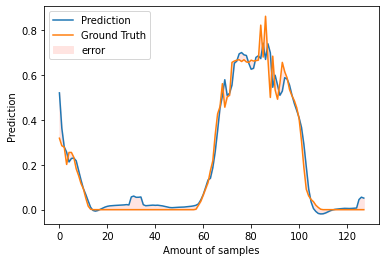

In [25]:
# %% Plotting
plt.plot(range(len(pred_y)), pred_y, label='Prediction')
plt.plot(range(len(pred_y)), test_y, label='Ground Truth')
plt.fill_between(range(len(pred_y)), pred_y.flatten(), test_y.flatten(), color='MistyRose',label='error')
plt.xlabel('Amount of samples')
plt.ylabel('Prediction')
plt.legend()
plt.show()
# %%

In [34]:
# prediction of feature
df_nwp_feature=pd.read_csv('.\\data\\GF001\\04 Fore_NWP_gf.csv',parse_dates=["Datetime"],index_col=[0])
df_nwp_30_days_fornt=df_nwp_feature.iloc[:7,:]
df_nwp_30_days_fornt.tail()
# set_model.predit(df_30_days_fornt) 假定一个新模型
# 合并nwp与pred_power，假定为df_30_days_past
df_30_days_past=df.iloc[-7:,:] #暂时用用
df_nwp_30_days_behind=df_nwp_feature.iloc[7:,:]
df_30_days_future=pd.read_csv('.\\data\\GF001\\04 Fore_NWP_gf.csv',parse_dates=["Datetime"],index_col=[0])
df_30_days_future
df_30_days_future.shape
df_30_days_future["Power(MW)"]=0
df_30_days_future

,Irradiance,Speed10,Direction10,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,
2022-07-15 00:00:00,0.0,4.7879,10.3477,27.89,990.79,89.94,0
2022-07-15 00:15:00,0.0,4.7817,10.6049,27.89,990.68,89.75,0
2022-07-15 00:30:00,0.0,4.7798,10.4871,27.88,990.51,89.62,0
2022-07-15 00:45:00,0.0,4.8969,7.0379,27.86,990.16,89.47,0
2022-07-15 01:00:00,0.0,5.1638,6.5607,27.85,989.78,89.30,0
...,...,...,...,...,...,...,...
2022-07-21 22:45:00,0.0,4.3397,40.7015,27.68,993.93,80.90,0
2022-07-21 23:00:00,0.0,4.4797,41.0175,27.65,994.44,0.00,0
2022-07-21 23:15:00,0.0,3.7592,38.3028,27.33,994.66,0.00,0


In [ ]:
# df_30_days_future=df_30_days_future[["Speed10" , "Direction10" , "Speed30" , "Direction30" , "Speed50" , "Direction50" , "Speed70" , "Direction70" , "Speed90" , "Direction90" , "Speed100" , "Direction100" , "Temper" , "Pressure" , "Humidity" , "Power(MW)"]]

In [35]:
old_scaled_array=scaler.transform(df_30_days_past)

In [36]:
old_scaled_array.shape

(7, 7)

In [37]:
new_scaled_array=scaler.transform(df_30_days_future)

In [38]:
new_scaled_array.shape

(672, 7)

In [39]:
new_scaled_df=pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,0]=np.nan
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)

In [40]:
full_df.shape

(679, 7)

In [41]:
full_df_scaled_array=full_df.values
all_data=[]
time_step=7
for i in range(time_step,len(full_df_scaled_array)):
  data_x=[]
  data_x.append(
    full_df_scaled_array[i-time_step :i , 0:full_df_scaled_array.shape[1]])
  data_x=np.array(data_x)
  prediction=grid_model.predict(data_x)
  all_data.append(prediction)
  full_df.iloc[i,0]=prediction

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


In [44]:
new_array=np.array(all_data)
new_array=new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array,7, axis=-1)
y_pred_future_30_days = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),7)))[:,0]
print(y_pred_future_30_days)

[  37.855953    -34.06422     -91.62217    -131.4453     -153.3882
 -163.16083    -164.78258    -161.32256    -165.2345     -177.29146
 -175.72148    -176.70683    -180.56793    -196.28424    -210.46777
 -217.02164    -212.61787    -203.47327    -193.50217    -184.88167
 -184.75836    -187.83328    -187.03436    -190.08083    -194.829
 -209.16917    -219.09453    -219.72224    -207.75064    -194.22734
 -180.73721    -169.57877    -167.69012    -174.6977     -176.26068
 -172.43202    -172.13492    -189.5039     -203.99399    -209.50262
 -203.79591    -198.27916    -190.58551    -184.388      -187.61533
 -192.09846    -196.28883    -204.95108    -217.21709    -238.02577
 -250.7964     -254.49988    -248.21922    -237.78773    -226.40976
 -216.14021    -213.67021    -212.47614    -217.27307    -228.54883
 -241.6617     -261.24036    -271.6046     -272.3013     -262.53915
 -251.6466     -242.7154     -235.35735    -234.80707    -236.0197
 -235.26863    -238.19717    -242.13629    -255.1825

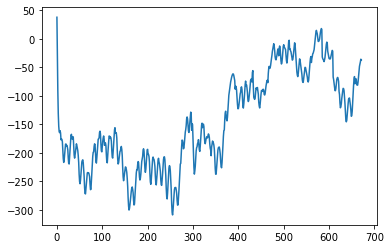

In [45]:
plt.plot(range(len(y_pred_future_30_days)), y_pred_future_30_days, label='Prediction')

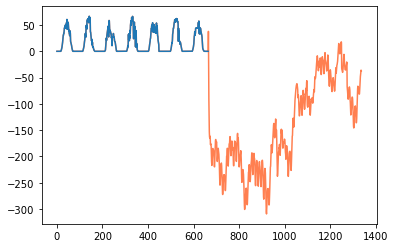

In [46]:
#绘制整体发电量图
total = np.hstack((df_y,y_pred_future_30_days))
plt.plot(range(len(total)), total, label='Prediction',color='coral')
plt.plot(range(len(df_y)), df_y, label='Prediction')